# Notebook to compare anu-tub simulations

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from cosima_cookbook import explore

In [2]:
db = '/g/data/x77/amh157/anu-tub/diagnostics/anu-tub.db'
session=cc.database.create_session(db)

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37321,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:41949,Total threads: 4
Dashboard: /proxy/40391/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:46267,


# Runs to compare

For now, we only have:
* `anu-tub-n3`: The latest version of the `zstar` control run. Note that this simulation uses the `julian` calendar (a mistake).
* `anu-tub-sigma`: First attempt at a terrain-following coordinate simulation. 

In [15]:
experiments=['anu-tub-n3','anu-tub-sigma']

# Spinup Diagnostics

These are variables from `ocean.stats`. Note that the time axis on these files is incompatible with `xarray`, hence the `decode_times=False` argument below.

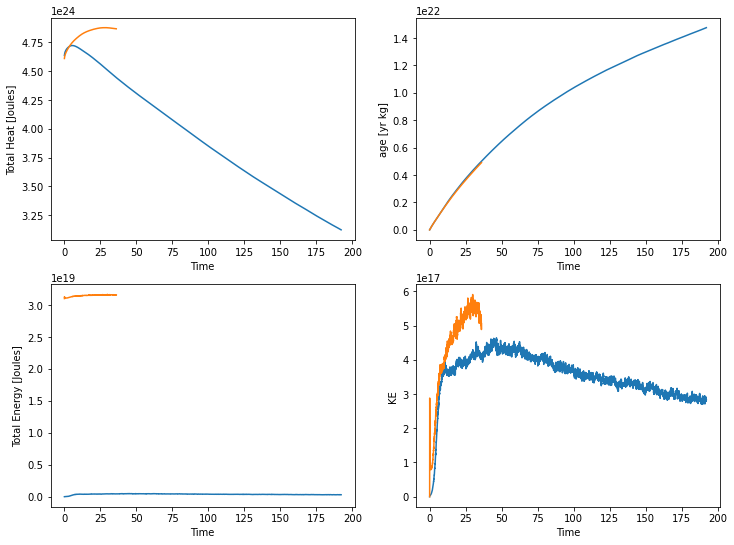

In [4]:
fig, ax = plt.subplots(2,2,figsize=(12,9))

for experiment in experiments:
    variable = 'Heat'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']/365
    darray.plot(ax=ax[0,0])
                                               
for experiment in experiments:
    variable = 'En'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']/365
    darray.plot(ax=ax[1,0])

for experiment in experiments:
    variable = 'age'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']/365
    darray.plot(ax=ax[0,1])
                                               
for experiment in experiments:
    variable = 'KE'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']/365
    darray.sum('Layer').plot(ax=ax[1,1])

# Extra Spinup Diagnostics

These diagnostics comes from regular diagnostic files. We are interested in the temperature evolution at different locations as well as some circulation metrics.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

Text(0.5, 1.0, 'Antarctic Shelf Temp')

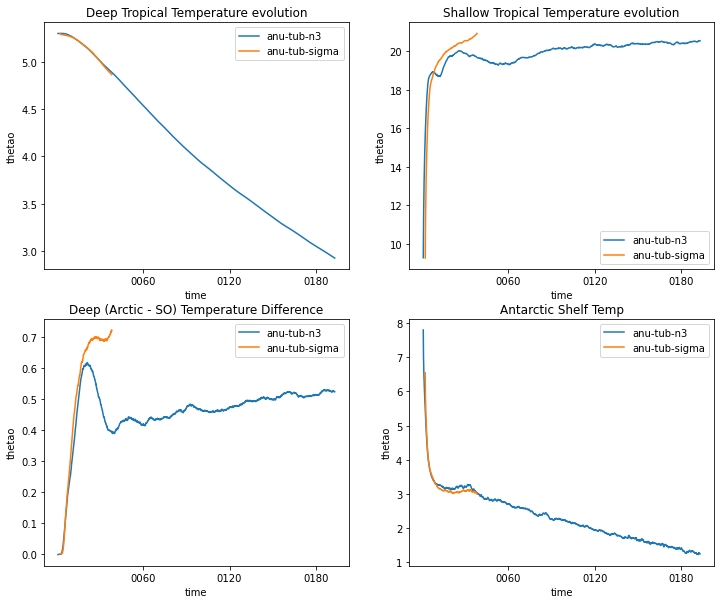

In [5]:
fig, ax = plt.subplots(2,2,figsize=(12,10))

for experiment in experiments:
    darray = cc.querying.getvar(experiment, 'thetao', session)

    deep_temp = darray.sel(z_l=slice(2000,4000)).mean('z_l').sel(yh=slice(-30,30)).mean('yh').sel(xh=slice(10,30)).mean('xh')
    deep_temp.plot(ax=ax[0,0],label=experiment)
    
    shallow_temp = darray.sel(z_l=slice(0,200)).mean('z_l').sel(yh=slice(-30,30)).mean('yh').sel(xh=slice(10,30)).mean('xh')
    shallow_temp.plot(ax=ax[0,1],label=experiment)
    
    deep_temp_diff = darray.sel(z_l=slice(3000,4000)).mean('z_l').sel(yh=slice(50,62)).mean('yh').mean('xh') - darray.sel(z_l=slice(3000,4000)).mean('z_l').sel(yh=slice(-62,-50)).mean('yh').mean('xh')
    deep_temp_diff.plot(ax=ax[1,0],label=experiment)

    shelf_temp = darray.mean('z_l').sel(yh=slice(-70,-65)).mean('yh').mean('xh')
    shelf_temp.plot(ax=ax[1,1],label=experiment)

ax[0,0].legend()
ax[0,0].set_title('Deep Tropical Temperature evolution')

ax[0,1].legend()
ax[0,1].set_title('Shallow Tropical Temperature evolution')

ax[1,0].legend()
ax[1,0].set_title('Deep (Arctic - SO) Temperature Difference')

ax[1,1].legend()
ax[1,1].set_title('Antarctic Shelf Temp')

Text(0.5, 1.0, 'Abyssal Overturning Circulation (Sv)')

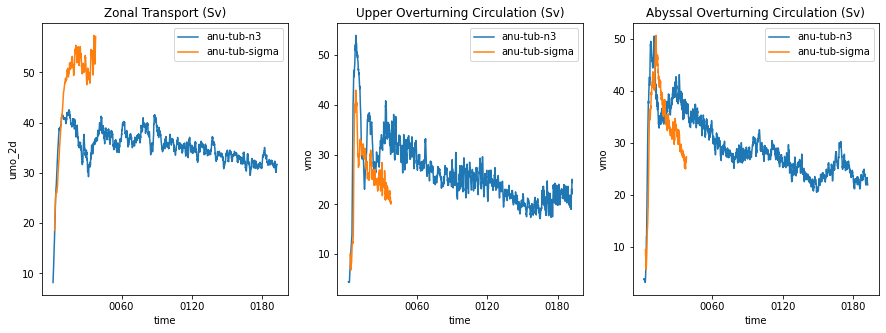

In [8]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

for experiment in experiments:
    darray = cc.querying.getvar(experiment, 'umo_2d', session, frequency='1 monthly')
    dp_trans = darray.isel(xq=0).sum('yh').rolling(time=12,center=True).mean().dropna('time').load()/1e9
    dp_trans.plot(ax=ax[0],label=experiment)

    darray = cc.querying.getvar(experiment, 'vmo', session)
    moc = darray.sum('xh').cumsum('rho2_l').sel(rho2_l=slice(1034,1038)).rolling(time=12,center=True).mean().dropna('time')/1e9
    amoc = moc.max(['rho2_l','yq']).load()
    gmoc = -moc.min(['rho2_l','yq']).load()
    amoc.plot(ax=ax[1],label=experiment)
    gmoc.plot(ax=ax[2],label=experiment)
    
ax[0].legend()
ax[0].set_title('Zonal Transport (Sv)')
ax[1].legend()
ax[1].set_title('Upper Overturning Circulation (Sv)')
ax[2].legend()
ax[2].set_title('Abyssal Overturning Circulation (Sv)')

# Plotting some maps

Mean fields are averaged over the last 20 years of simulation. Snapshots take the last day simulated.

In [9]:
def plot_mercator(ax,X0,Y0):
    X,Y = np.meshgrid(X0,Y0)
    X_alt = (X - 20)*np.cos(Y*np.pi/180) + 20
    
    ax.set_frame_on(False)
    ax.plot(X_alt[:,0],Y[:,0],'k')
    ax.plot(X_alt[:,-1],Y[:,-1],'k')
    ax.plot([X_alt[-1,0], X_alt[-1,-1]],[69.8, 69.8],'k')
    ax.plot([X_alt[0,0], X_alt[0,-1]],[-70, -70],'k')
    ax.set_xlabel('Longitude')
    
    ax.set_ylim(ymin=-70,ymax=70)
    plt.setp(ax,'xticks',[10, 20, 30])
    return X_alt, Y

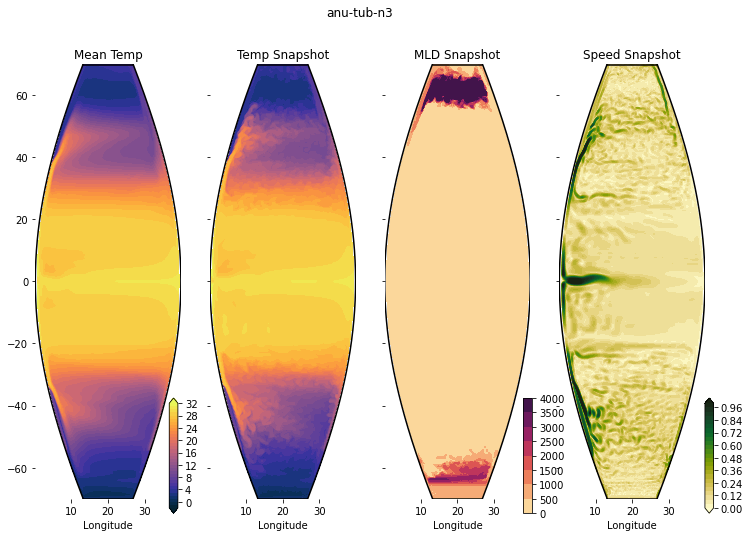

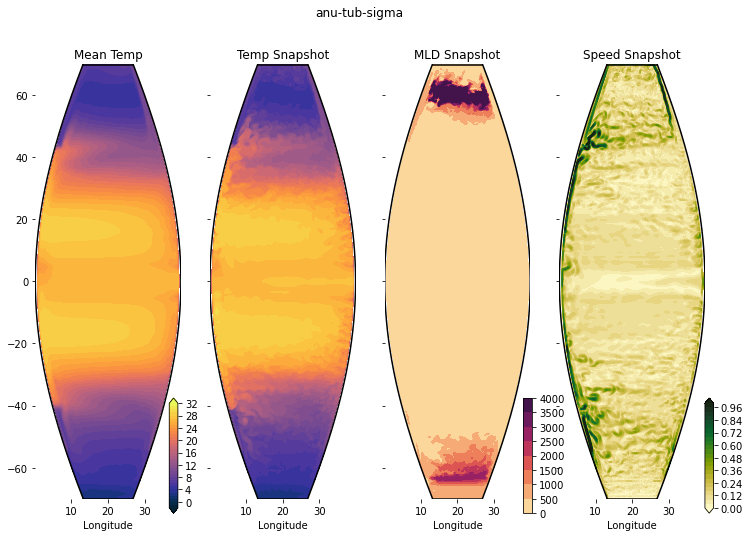

In [10]:
for experiment in experiments:
    fig, ax = plt.subplots(1,4,figsize=(12,8))
    vlev = np.linspace(-2,32,35)

    darray = cc.querying.getvar(experiment, 'tos', session,n=-20)
    temp_surf = darray.mean('time').load()
    X,Y = plot_mercator(ax[0],temp_surf.coords['xh'],temp_surf.coords['yh'])
    p1=ax[0].contourf(X,Y,temp_surf,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[0].set_title('Mean Temp')
    
    darray = cc.querying.getvar(experiment, 'tos', session,n=-20)
    temp_snap = darray.isel(time=-1).load()
    X,Y = plot_mercator(ax[1],temp_snap.coords['xh'],temp_snap.coords['yh'])
    p1=ax[1].contourf(X,Y,temp_snap,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[1].set_title('Temp Snapshot')
    ax[1].set_yticklabels('')
    
    cbax = plt.axes([0.28,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)

    darray = cc.querying.getvar(experiment, 'mlotst', session,n=-20)
    mld_snap = darray.isel(time=-1).load()
    X,Y = plot_mercator(ax[2],mld_snap.coords['xh'],mld_snap.coords['yh'])
    p1=ax[2].contourf(X,Y,mld_snap,cmap=cm.cm.matter)
    ax[2].set_title('MLD Snapshot')
    ax[2].set_yticklabels('')


    cbax = plt.axes([0.69,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)
    
    slev = np.linspace(0,1,26)
    darray = cc.querying.getvar(experiment, 'uo', session,n=-20)
    u_snap = darray.isel(time=-1).isel(z_l=0).load()
    darray = cc.querying.getvar(experiment, 'vo', session,n=-20)
    v_snap = darray.isel(time=-1).isel(z_l=0).load()
    speed = (u_snap.values[:,:-1]**2 + v_snap[:-1,:].values**2)**(0.5)
    X,Y = plot_mercator(ax[3],temp_snap.coords['xh'],temp_snap.coords['yh'])
    p1=ax[3].contourf(X,Y,speed,levels=slev,extend='both',cmap=cm.cm.speed)
    ax[3].set_title('Speed Snapshot')
    ax[3].set_yticklabels('')

    cbax = plt.axes([0.9,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)
    
    plt.suptitle(experiment)


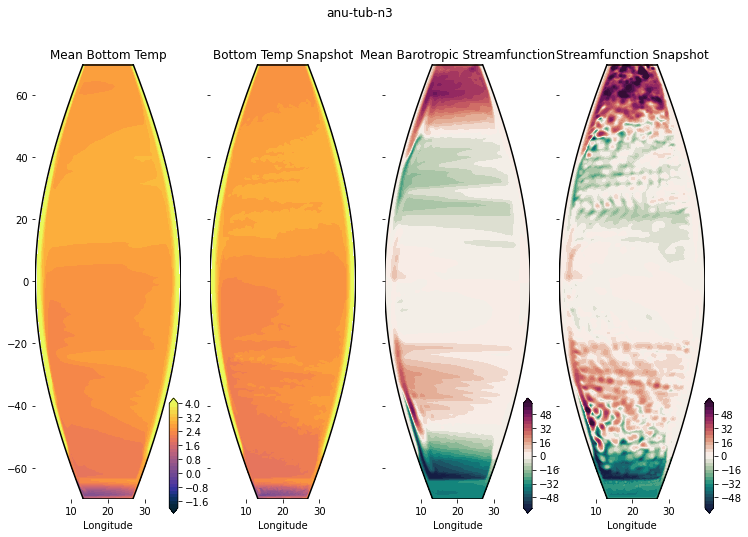

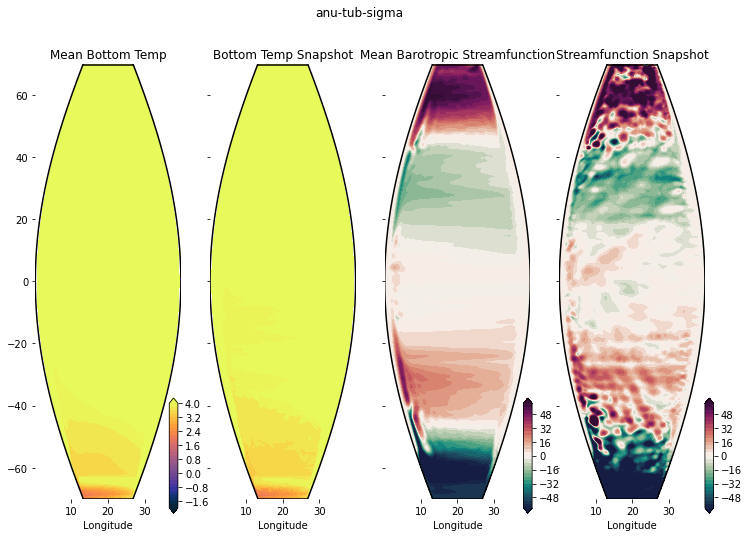

In [12]:
for experiment in experiments:

    fig, ax = plt.subplots(1,4,figsize=(12,8))
    vlev = np.linspace(-2,4,31)

    darray = cc.querying.getvar(experiment, 'tob', session,n=-20)
    temp_surf = darray.mean('time').load()
    X,Y = plot_mercator(ax[0],temp_surf.coords['xh'],temp_surf.coords['yh'])
    p1=ax[0].contourf(X,Y,temp_surf,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[0].set_title('Mean Bottom Temp')

    darray = cc.querying.getvar(experiment, 'tob', session,n=-20)
    temp_snap = darray.isel(time=-1).load()
    X,Y = plot_mercator(ax[1],temp_snap.coords['xh'],temp_snap.coords['yh'])
    p1=ax[1].contourf(X,Y,temp_snap,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[1].set_title('Bottom Temp Snapshot')
    ax[1].set_yticklabels('')

    cbax = plt.axes([0.28,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)


    darray = cc.querying.getvar(experiment, 'umo_2d', session,n=-20, frequency='1 monthly')
    psi = darray.mean('time').cumsum('yh').load()
    psi = (psi - psi.isel(xq=-1).isel(yh=-1))/1e9
    X,Y = plot_mercator(ax[2],psi.coords['xq'],psi.coords['yh'])
    p1=ax[2].contourf(X,Y,psi,cmap=cm.cm.curl,levels=np.linspace(-60,60,31),extend='both')
    ax[2].set_title('Mean Barotropic Streamfunction')
    ax[2].set_yticklabels('')

    cbax = plt.axes([0.69,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)


    darray = cc.querying.getvar(experiment, 'umo_2d', session,n=-1, frequency='1 daily')
    psi = darray.isel(time=-1).cumsum('yh').load()
    psi = (psi - psi.isel(xq=-1).isel(yh=-1))/1e9
    X,Y = plot_mercator(ax[3],psi.coords['xq'],psi.coords['yh'])
    p1=ax[3].contourf(X,Y,psi,cmap=cm.cm.curl,levels=np.linspace(-60,60,31),extend='both')
    ax[3].set_title('Streamfunction Snapshot')
    ax[3].set_yticklabels('')

    cbax = plt.axes([0.9,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)
    
    plt.suptitle(experiment)


# A temperature profile
Note that I'm not averaging zero-thickness cells properly here.

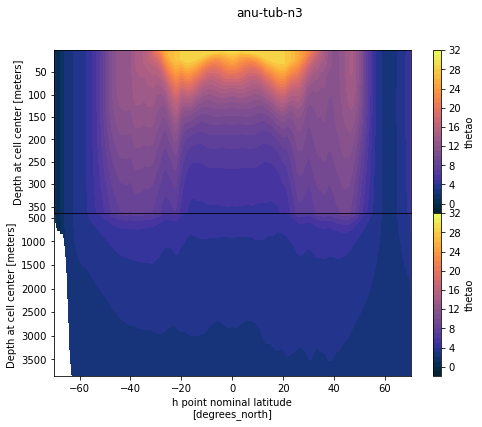

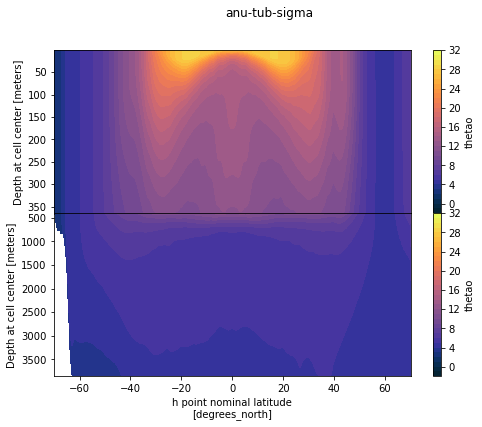

In [13]:
for experiment in experiments:
    fig, ax = plt.subplots(2,1,figsize=(8,6))
    plt.subplots_adjust(hspace=0)
    vlev = np.linspace(-2,32,35)

    darray = cc.querying.getvar(experiment, 'thetao', session,n=-20)
    temp_slice = darray.mean('time').sel(xh=slice(10,30)).mean('xh').load()

    temp_slice.sel(z_l=slice(0,400)).plot.contourf(ax=ax[0],levels=vlev,yincrease=False,cmap=cm.cm.thermal)
    temp_slice.sel(z_l=slice(400,4000)).plot.contourf(ax=ax[1],levels=vlev,yincrease=False,cmap=cm.cm.thermal)

    plt.suptitle(experiment)
    

# Overturning Circulation


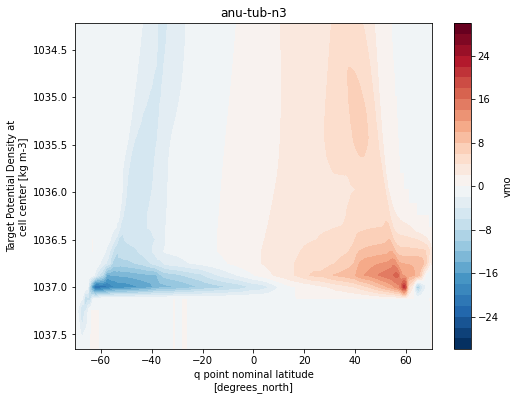

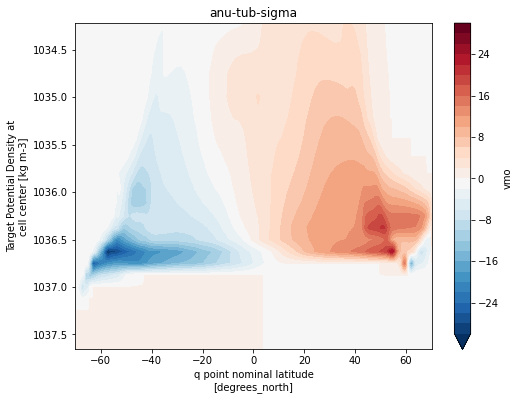

In [14]:
for experiment in experiments:
    fig = plt.figure(figsize=(8,6))
    darray = cc.querying.getvar(experiment, 'vmo', session,n=-20)
    moc = darray.sum('xh').mean('time').cumsum('rho2_l')/1e9
    moc.sel(rho2_l=slice(1034,1038)).plot.contourf(levels=np.linspace(-30,30,31),yincrease=False)
    plt.title(experiment)